Interprétation de modèles avec ELI5 , LIME et SHAP

L'idée de ce tutoriel est de fournir des outils et des techniques permettant d’interpréter des modèles d'apprentissage. Ce tutoriel est quasi identique à celui disponible sur ce lien : https://towardsdatascience.com/explainable-artificial-intelligence-part-3-hands-on-machine-learning-model-interpretation-e8ebe5afc608. A la différence du tutoriel original celui-ci contient :
- L'essentiel
- Mise à jour des librairies et des méthodes utilisées
- Des commentaires en plus

Utilisation de ces 3 packages :
- ELI5
- Skater
- SHAP

5 concepts sont abordés dans ce tutoriels : 
    - Importance des variables
    - Partielle dépendance
    - Explication d'un modèle de prédiction avec une interprétation locale
    - Explication d'un modèle de prédiction avec SHAP
    - Dépendence et intéractions entre variables avec SHAP

Jeu de données : Adult Data Set

| Attribute Name 	| Type 	| Description 	|
|-----------------------	|----------------------------	|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------	|
| Age 	| Continuous 	| Represents age of the person 	|
| Workclass 	| Categorical 	| Represents the nature of working class\category<br>(Private, Self-emp-not-inc, Self-emp-inc, Federal-gov,  <br>Local-gov, State-gov, Without-pay, Never-worked) 	|
| Education-Num 	| Categorical 	| Numeric representation of educational qualification.<br>Ranges from 1-16.<br>(Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, <br>9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool) 	|
| Marital Status 	| Categorical 	| Represents the marital status of the person<br>(Married-civ-spouse, Divorced, Never-married, Separated, <br>Widowed, Married-spouse-absent, Married-AF-spouse) 	|
| Occupation 	| Categorical 	| Represents the type of profession\job of the person<br>(Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, <br>Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, <br>Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, <br>Armed-Forces) 	|
| Relationship 	| Categorical 	| Represents the relationship status of the person<br>(Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried) 	|
| Race 	| Categorical 	| Represents the race of the person<br>(White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black) 	|
| Sex 	| Categorical 	| Represents the gender of the person<br>(Female, Male) 	|
| Capital Gain 	| Continuous 	| The total capital gain for the person 	|
| Capital Loss 	| Continuous 	| The total capital loss for the person 	|
| Hours per week 	| Continuous 	| Total hours spent working per week 	|
| Country 	| Categorical 	| The country where the person is residing 	|
| Income Label (labels) 	| Categorical  (class label) 	| The class label column is the one we want to predict<br>(False: Income <= \$50K & True: Income > \$50K) 	

Jeu de données de 32 561 individus décrit par 12 variables dont la variable cible "Income Label"

Pour l'installation des différents package ils peuvent se faire avec la commande conda (si vous possédez anaconda ou pip).
- conda or pip install shap
- conda or pip install eli5
- conda or pip install skater

In [113]:
#Chargement des librairies et des dépendances
import pandas as pd
import numpy as np
from collections import Counter
import shap
import eli5
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.preprocessing import label_binarize
from scipy import interp
from sklearn.metrics import roc_curve, auc 
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

shap.initjs()

In [114]:
#Fonction qui vont nous servir pour résumer les performances de notre modèle de prédiction
def get_metrics(true_labels, predicted_labels):
    print('Accuracy:', np.round(metrics.accuracy_score(true_labels, predicted_labels),4))
    print('Precision:', np.round(metrics.precision_score(true_labels, predicted_labels,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(true_labels, predicted_labels,average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(true_labels, predicted_labels,average='weighted'),4))


def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]
    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, labels=classes)
    cm_frame = pd.DataFrame(data=cm, columns=pd.MultiIndex(levels=[['Predicted:'], classes],labels=level_labels),index=pd.MultiIndex(levels=[['Actual:'], classes],labels=level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):
    report = metrics.classification_report(y_true=true_labels,y_pred=predicted_labels,labels=classes) 
    print(report)
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

#### Chargement et description des données

In [3]:
#Ce dataset fourni par shap est déjà nettoyé
data,labels = shap.datasets.adult(display=True)

In [4]:
data.head()

Age          Workclass  Education-Num       Marital Status  \
0  39.0          State-gov           13.0        Never-married   
1  50.0   Self-emp-not-inc           13.0   Married-civ-spouse   
2  38.0            Private            9.0             Divorced   
3  53.0            Private            7.0   Married-civ-spouse   
4  28.0            Private           13.0   Married-civ-spouse   

           Occupation    Relationship    Race      Sex  Capital Gain  \
0        Adm-clerical   Not-in-family   White     Male        2174.0   
1     Exec-managerial         Husband   White     Male           0.0   
2   Handlers-cleaners   Not-in-family   White     Male           0.0   
3   Handlers-cleaners         Husband   Black     Male           0.0   
4      Prof-specialty            Wife   Black   Female           0.0   

   Capital Loss  Hours per week         Country  
0           0.0            40.0   United-States  
1           0.0            13.0   United-States  
2           0.0            40.0   United-States  
3           0.0            40.0   United-States  
4           0.0            40.0            Cuba

In [5]:
data.describe()

Age  Education-Num  Capital Gain  Capital Loss  Hours per week
count  32561.000000   32561.000000  32561.000000  32561.000000    32561.000000
mean      38.581646      10.080679   1077.648804     87.303833       40.437454
std       13.640432       2.572720   7385.291992    402.960205       12.347429
min       17.000000       1.000000      0.000000      0.000000        1.000000
25%       28.000000       9.000000      0.000000      0.000000       40.000000
50%       37.000000      10.000000      0.000000      0.000000       40.000000
75%       48.000000      12.000000      0.000000      0.000000       45.000000
max       90.000000      16.000000  99999.000000   4356.000000       99.000000

In [116]:
print("Data Shape : ", data.shape,"\n","Labels Shape :", labels.shape,'\n\n')
print("---------------------Distributions ---------------","\n")
print("Salaire < 50k : ",Counter(labels)[0],
      "\n",
      "Salaire > 50k :",Counter(labels)[1])

Data Shape :  (32561, 12) 
 Labels Shape : (32561,) 


---------------------Distributions --------------- 

Salaire < 50k :  24720 
 Salaire > 50k : 7841


#### Transformation de données
L'idée ici est d'encoder les différentes catégories des variables catégorielles en numérique.

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 12 columns):
Age               32561 non-null float32
Workclass         32561 non-null int8
Education-Num     32561 non-null float32
Marital Status    32561 non-null int8
Occupation        32561 non-null int8
Relationship      32561 non-null int8
Race              32561 non-null int8
Sex               32561 non-null int8
Capital Gain      32561 non-null float32
Capital Loss      32561 non-null float32
Hours per week    32561 non-null float32
Country           32561 non-null int8
dtypes: float32(5), int8(7)
memory usage: 858.6 KB


In [118]:
#Workclass, Marital Status, Occupation, Relationship, Race, Sex et Country
cat_cols = data.select_dtypes(['category']).columns

In [119]:
data[cat_cols] = data[cat_cols].apply(lambda x: x.cat.codes)
data.head()

Age  Workclass  Education-Num  Marital Status  Occupation  Relationship  \
0  39.0          7           13.0               4           1             1   
1  50.0          6           13.0               2           4             0   
2  38.0          4            9.0               0           6             1   
3  53.0          4            7.0               2           6             0   
4  28.0          4           13.0               2          10             5   

   Race  Sex  Capital Gain  Capital Loss  Hours per week  Country  
0     4    1        2174.0           0.0            40.0       39  
1     4    1           0.0           0.0            13.0       39  
2     4    1           0.0           0.0            40.0       39  
3     2    1           0.0           0.0            40.0       39  
4     2    0           0.0           0.0            40.0        5

#### Split Train et Test 
Jeu de données encodé

In [120]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

In [121]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((22792, 12), (9769, 12), (22792,), (9769,))

#### Split Train et Test (bis)
Jeu de données avec libellé (cela va nous servir plus tard pour l'interprétation)

In [122]:
data_disp, labels_disp = shap.datasets.adult(display=True)
X_train_disp, X_test_disp, y_train_disp, y_test_disp = train_test_split(data_disp, labels_disp, test_size=0.3, random_state=42)
print(X_train_disp.shape, X_test_disp.shape)
X_train_disp.head(3)

(22792, 12) (9769, 12)


Age          Workclass  Education-Num       Marital Status  \
19749  34.0   Self-emp-not-inc            9.0   Married-civ-spouse   
1216   48.0   Self-emp-not-inc           10.0   Married-civ-spouse   
27962  23.0          State-gov           10.0   Married-civ-spouse   

             Occupation Relationship                 Race      Sex  \
19749   Farming-fishing         Wife                White   Female   
1216       Craft-repair      Husband   Amer-Indian-Eskimo     Male   
27962    Prof-specialty      Husband                White     Male   

       Capital Gain  Capital Loss  Hours per week         Country  
19749           0.0        2179.0            12.0   United-States  
1216         7688.0           0.0            40.0   United-States  
27962           0.0           0.0            30.0   United-States

#### Entrainement d'un modèle XGboost

In [123]:
%%time

import xgboost as xgb
xgc = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                        objective='binary:logistic', random_state=42)
xgc.fit(X_train, y_train)

Wall time: 12.4 s


In [124]:
#Prédictions
predictions = xgc.predict(X_test)

#### Performance du modèle

In [125]:
class_labels = list(set(labels))
display_model_performance_metrics(true_labels=y_test, 
                                      predicted_labels=predictions, 
                                      classes=class_labels)

Model Performance metrics:
------------------------------
Accuracy: 0.8712
Precision: 0.8671
Recall: 0.8712
F1 Score: 0.8681

Model Classification report:
------------------------------
              precision    recall  f1-score   support

       False       0.90      0.94      0.92      7455
        True       0.76      0.67      0.71      2314

   micro avg       0.87      0.87      0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                   False True 
Actual: False       6972   483
        True         775  1539


#### Interprétation par défaut du modèle
- Documentation sur les calculs derrière l'importance des variables : https://christophm.github.io/interpretable-ml-book/feature-importance.html#theory-3
- Différence entre Weight, Gain et Coverage : https://datascience.stackexchange.com/questions/12318/how-do-i-interpret-the-output-of-xgboost-importance

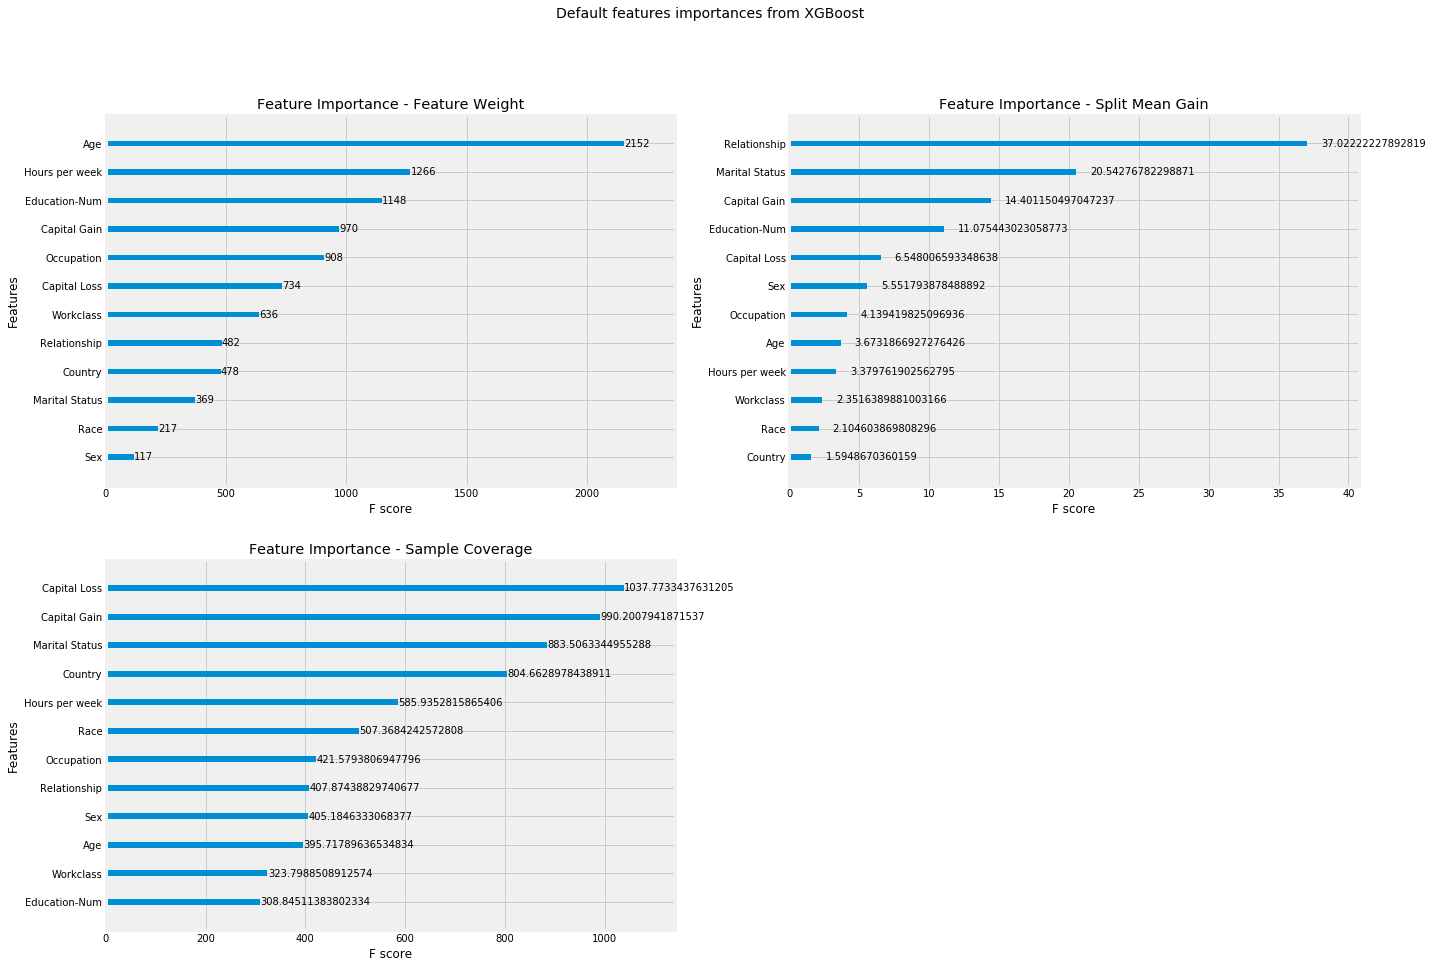

In [127]:
fig = plt.figure(figsize = (20, 15))
title = fig.suptitle("Default features importances from XGBoost", fontsize=14)

#Nombre de fois qu'une variable apparaît dans un arbre "Weight"
ax1 = fig.add_subplot(2,2, 1)
xgb.plot_importance(xgc, importance_type='weight', ax=ax1)
t=ax1.set_title("Feature Importance - Feature Weight")

#Basé sur le gain moyen des divisions utilisant la variable "Gain"
ax2 = fig.add_subplot(2,2, 2)
xgb.plot_importance(xgc, importance_type='gain', ax=ax2)
t=ax2.set_title("Feature Importance - Split Mean Gain")

#Basé le nombre moyen d'échantillons affectés par la scissions utilisant la variable "Coverage"
ax3 = fig.add_subplot(2,2, 3)
xgb.plot_importance(xgc, importance_type='cover', ax=ax3)
t=ax3.set_title("Feature Importance - Sample Coverage")

#### Interprétation du modèle avec ELI5.
ELI5 est un package Python qui aide à déboguer les classifieurs et à expliquer leurs prédictions de manière intuitive et facile à comprendre. C’est le plus simple des trois packages.  Cependant, il s’appuie principalement que sur les modèles de type arbre et linéaire. Il permet de faire une interprétation globale prédictions et local (individuelle).
- Doc ELI5 avec un exemple : https://eli5.readthedocs.io/en/latest/tutorials/xgboost-titanic.html


In [129]:
#Feature Importance avec ELI5
#Rien ne change du feature importance classique. La méthode "gain" est sélectionné par défaut
eli5.show_weights(xgc)

Autre moyen d'interpréter les prédictions du modèle, consiste à les examiner de manière individuelle. En règle générale, ELI5 effectue cette opération en affichant des pondérations pour chaque variable, illustrant son influence potentielle sur la décision finale des prédictions de tous les arbres. 
- Le calcul du poids ("Weight") est décrit ici http://blog.datadive.net/interpreting-random-forests/.

In [130]:
#Cas ou la personne est prédit ayant un salaire inférieur à 50k et a réellement un salaire inf à 50k
#y : correspond à la prédiction de l'individu
#probability : proba prédite d'être inf à 50k
#score : somme des contributions
ind_choisi = 0
print('Actual Label:', y_test[ind_choisi])
print('Predicted Label:', predictions[ind_choisi])
eli5.show_prediction(xgc, X_test.iloc[ind_choisi], 
                     show_feature_values=True)

Actual Label: False
Predicted Label: False


On s'aperçoit que les variables qui ont le plus influencé l'individu 0 à être prédit comme ayant un salaire inf. à 50k sont : 
- Age
- Hous per week
- Marital Status
- Occupation
- Relationship

De plus Eli5 fournit le couple (variable - valeurs) ce qui peut être intéressant d'analyser. Mais nous verrons que ce couple a plus de sens pour les autres packages tels que LIME et SHAP.

In [131]:
#Cas ou la personne est prédit ayant un salaire supérieur à 50k et a réllement un salaire sup. à 50k
ind_choisi =2
print('Actual Label:', y_test[ind_choisi])
print('Predicted Label:', predictions[ind_choisi])
eli5.show_prediction(xgc, X_test.iloc[ind_choisi], 
                     feature_names=list(data.columns),
                     show_feature_values=True)

Actual Label: True
Predicted Label: True


On s'aperçoit que les variables qui ont le plus influencé l'individu 2 à être prédit comme ayant un salaire sup. à 50k sont : 
- Education-Num
- RelationShip
- Occupation
- Hous per week
- Marital Status

## Interprétation du Modèle avec Skater

Skater est un package qui permet l’interprétation de plusieurs modèles (linéaire, non linéaire). Plus élaboré que ELI5 sur certains points comme l'interprétation local de prédiction (influence des variables sur la prédiction d'un individu) et l'interprétation globale.
- Documentation : https://datascienceinc.github.io/Skater/
- Starter : https://github.com/datascienceinc/Skater

De base skater est un outil dérivé du package LIME cependant le projet ayant pris de l'ampleur il est devenu à lui-même un outil permettant d'interpréter des modèles

In [132]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

In [209]:
#Création d'un objet interprétation. Tous process utilisant skater doit passer par la création de cet objet 
interpreter = Interpretation(training_data=X_test, feature_names=list(data.columns))

In [137]:
#InMemoryModel est la méthode utilisée pour l'interprétation d'un modèle en local
#DeployedModel est la méthode utilisée pour l'interprétation d'un modèle accessible via une API (voir doc)
interpreter_model = InMemoryModel(xgc.predict_proba, examples=X_train, target_names=['$50K or less', 'More than $50K'])

##### Global Interprétation
Skater a sa façon de calculer les features importances
- Calcul des coefficients attribués aux variables : https://datascienceinc.github.io/Skater/reference/interpretation.html#feature-importance

[12/12] features ████████████████████ Time elapsed: 3 seconds

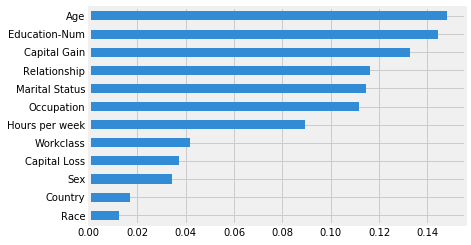

In [138]:
plots = interpreter.feature_importance.plot_feature_importance(interpreter_model, ascending=False)

# Partielle Dépendance 

Le graphe de dépendance partielle (PDP ou PD) montre l'effet marginal d'une variable sur les prédictions. C'est à dire qu'il nous montre si la relation entre la variable cible et la variable choisie est linéaire, monotone ou plus complexe. 

Skater permet de visualiser les PDP en une ou deux dimensions. Les variables choisies par la suite pour la visualisation des différents PDP sont celles que nos interpréteurs ont jugés être discriminante dans les prédictions de nos classes.

[44/44] grid cells ████████████████████ Time elapsed: 10 seconds

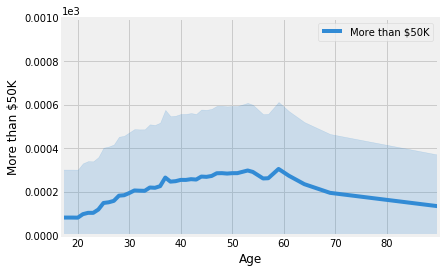

In [183]:
#Partielle dépendance de l'âge et des prédictions
# !! Pb d'affichage !! en ordonnée nous retrouvons les probabilités d'avoir un salaire sup. à 50k 
age_pdp = interpreter.partial_dependence.plot_partial_dependence(['Age'], interpreter_model, grid_resolution=50, 
                                                           grid_range=(0,1),with_variance=True, figsize = (6, 4))
new_y_lim = age_pdp[0][1].set_ylim(0, 1)
min_x, max_x = age_pdp[0][1].get_xlim()
new_x_lim = age_pdp[0][1].set_xticks(np.arange(20, 90, 10))

Le graphe nous montre que les personnes se trouvant entre 30 et 50 ans ont plus de chance de gagner 50k contrairement aux plus jeunes ou plus âgées.

[16/16] grid cells ████████████████████ Time elapsed: 12 seconds

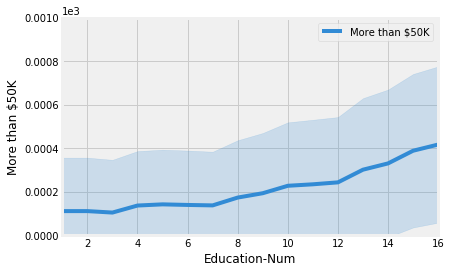

In [184]:
education_pdp = interpreter.partial_dependence.plot_partial_dependence(['Education-Num'], interpreter_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (6, 4))
y_lim = education_pdp[0][1].set_ylim(0, 1)

Sans surprise Le graphe nous montre que les personnes ayant fait plus d'études ont plus de chance de gagner 50k.

[6/6] grid cells ████████████████████ Time elapsed: 10 seconds

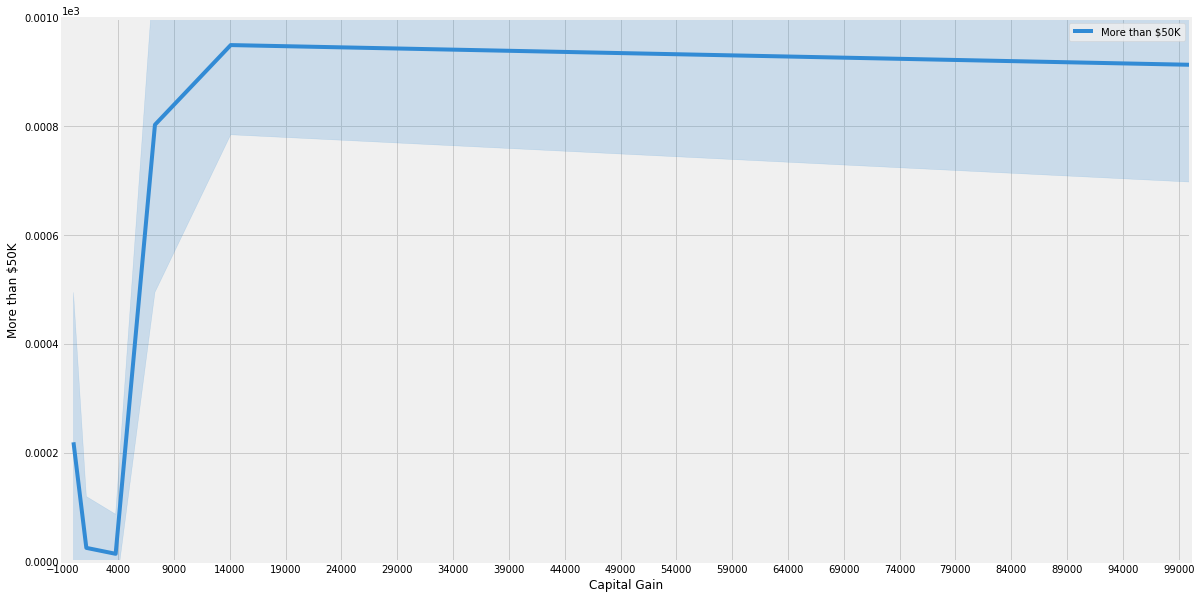

In [186]:
capital_gain_pdp = interpreter.partial_dependence.plot_partial_dependence(['Capital Gain'], interpreter_model, grid_resolution=50, 
                                                           grid_range=(0,1), 
                                                           with_variance=True, figsize = (18, 10))
yl = capital_gain_pdp[0][1].set_ylim(0, 1)
s, e = capital_gain_pdp[0][1].get_xlim()
xl = capital_gain_pdp[0][1].set_xticks(np.arange(-1000, e, 5000))

Sans surprise plus le capital gain est élevé plus on a de chance de gagner plus de 50k

In [187]:
#Construction d'une table de référence
pd.concat([data_disp[['Relationship']], data[['Relationship']]],axis=1).drop_duplicates()

Relationship  Relationship
0     Not-in-family             1
1           Husband             0
4              Wife             5
12        Own-child             3
17        Unmarried             4
74   Other-relative             2

[6/6] grid cells ████████████████████ Time elapsed: 11 seconds

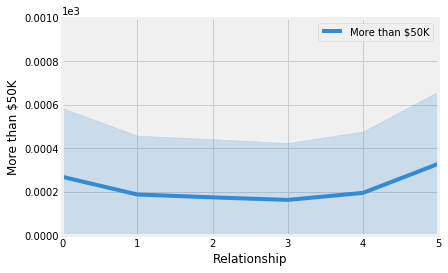

In [188]:
relationship_pdp = interpreter.partial_dependence.plot_partial_dependence(['Relationship'], interpreter_model, grid_resolution=50, 
                                                           grid_range=(0,1),
                                                           with_variance=True, figsize = (6, 4))
yl = relationship_pdp[0][1].set_ylim(0, 1)

Les couples (husband ou Wife) ont plus de chance d'avoir un salaire sup. à 50k

In [189]:
pd.concat([data_disp[['Occupation']], data[['Occupation']]],axis=1).drop_duplicates()

Occupation  Occupation
0          Adm-clerical           1
1       Exec-managerial           4
2     Handlers-cleaners           6
4        Prof-specialty          10
6         Other-service           8
13                Sales          12
14         Craft-repair           3
15     Transport-moving          14
16      Farming-fishing           5
17    Machine-op-inspct           7
24         Tech-support          13
27                    ?           0
30      Protective-serv          11
442        Armed-Forces           2
536     Priv-house-serv           9

[15/15] grid cells ████████████████████ Time elapsed: 12 seconds

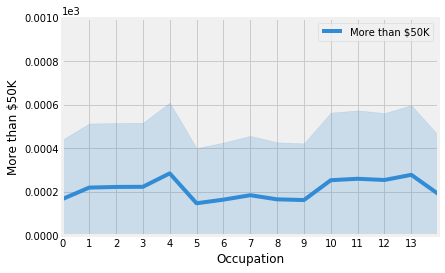

In [190]:
occupation_pdp = interpreter.partial_dependence.plot_partial_dependence(['Occupation'], interpreter_model, grid_resolution=50, 
                                                           grid_range=(0,1),
                                                           with_variance=True, figsize = (6, 4))
yl = occupation_pdp[0][1].set_ylim(0, 1)
xl = occupation_pdp[0][1].set_xticks(np.arange(0,14,1))

Exec. Managerial, Prof speciality, Protective-serv, Sales et Tech support ont plus de chance d'avoir un salaire sup. à 50k

#### PDP bidirectionnel 
Cela permet de montrer les interactions entre deux variables et leurs effets sur la variable cible. Les variables choisies sont «Age» et «Education-Num».

[1136/1136] grid cells ████████████████████ Time elapsed: 34 seconds

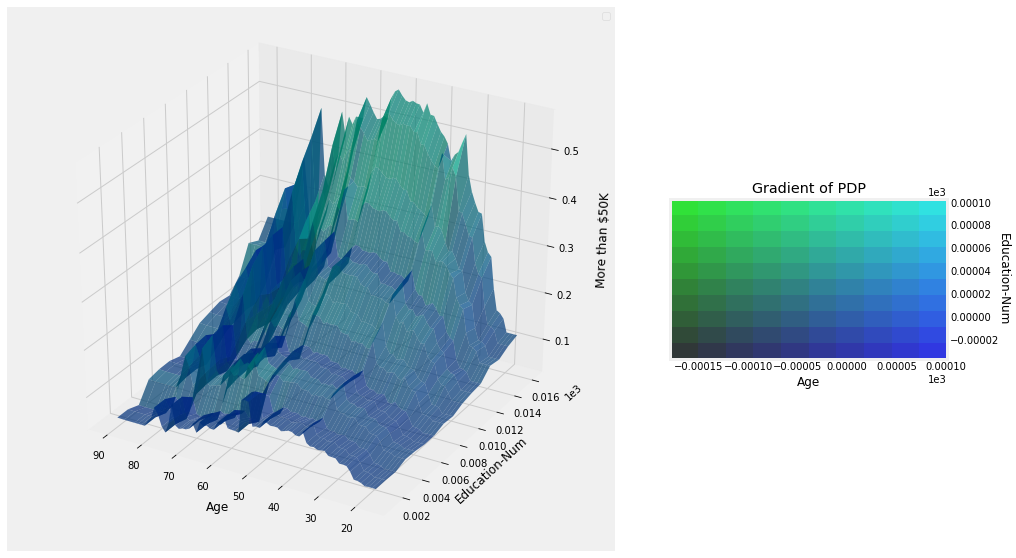

In [191]:
age_edu_pdp = interpreter.partial_dependence.plot_partial_dependence([('Age', 'Education-Num')], 
                                                                    interpreter_model, grid_range=(0,1),
                                                                    figsize=(15, 10),
                                                                    grid_resolution=100)

On remarque que les personnes ayant un niveau d'étude élevé entre 30 et 50 ans ont plus de chance d'avoir un salaire sup à 50k

[160/160] grid cells ████████████████████ Time elapsed: 15 seconds

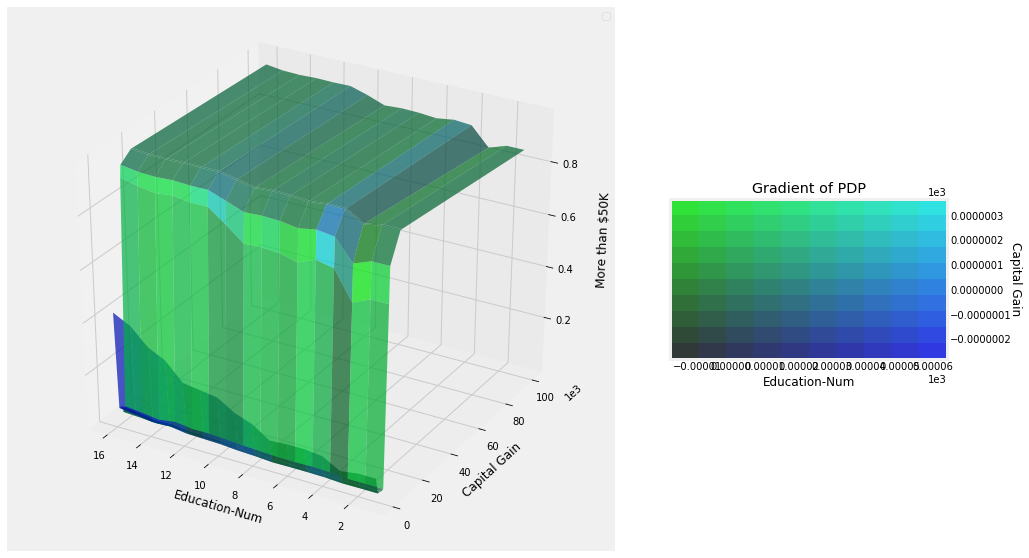

In [192]:
edu_capital_gain_pdp = interpreter.partial_dependence.plot_partial_dependence([('Education-Num','Capital Gain')], 
                                                                    interpreter_model, grid_range=(0,1),
                                                                    figsize=(15, 10),
                                                                    grid_resolution=100)

Avoir un haut niveau d'étude et un capital élevé augmente les chances d'avoir un salaire sup. à 50k

# Interprétation local du modèle avec Skater

LIME (Local Interpretable Model-Agnostic Explanations) se focalise sur les individus afin d'expliquer leurs prédictions (interprétation local).
LIME se base sur la méthode de perturbation des distributions de variables afin de voir l'influence de celles-ci dans les prédictions. LIME peut s'appliquer à de nombreux type de problématique et de données (numérique, catégorielle, mixte, image, textuelle).
- Papier scientifique LIME : https://arxiv.org/abs/1602.04938
- Starter : https://github.com/marcotcr/lime
- Documentation : https://lime-ml.readthedocs.io/en/latest/

In [193]:
#On relance xgboost avec numpy
xgc_np = xgb.XGBClassifier(n_estimators=500, max_depth=5, base_score=0.5,
                           objective='binary:logistic', random_state=42)
#Valeurs 
xgc_np.fit(X_train.values, y_train)
xgc_np.predict_proba(X_test.values)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

##### Création de l'objet explainer

In [195]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer
exp = LimeTabularExplainer(X_test.values, feature_names=list(data.columns), 
                           discretize_continuous=True, 
                           class_names=['$50K or less', 'More than $50K'])

##### Interprétation locale

##### Tableau (Feature - Value) : 
Résume les valeurs réelles de l'individu
##### Graphe tree : 
Montre les contributions de chacune des variables qui influent le plus sur le fait d'avoir un salaire inf. à 50k

In [197]:
#ici l'individu prédit a un salaire inf à 50k
#Notre modèle a prédit que son salaire est inf à 50k
ind_choisi = 0
print('Actual Label:', y_test[ind_choisi])
print('Predicted Label:', predictions[ind_choisi])
exp.explain_instance(X_test.iloc[ind_choisi].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: False
Predicted Label: False


Les variables qui influent le plus cette prédiction sont capital gain, l'âge et hous per week. Ici le couple (variable - valeurs) prend un sens. 
###### Exemple : 
Le fait d'avoir un capital inférieur ou égale à 0 influe la prédiction vers la classe salaire inf. à 50k.

In [198]:
#Prenons le cas réel d'une personne ayant un salaire sup. à 50k
ind_choisi = 2
print('Actual Label:', y_test[ind_choisi])
print('Predicted Label:', predictions[ind_choisi])
exp.explain_instance(X_test.iloc[ind_choisi].values, xgc_np.predict_proba).show_in_notebook()

Actual Label: True
Predicted Label: True


Dans ce cas on peut voir que notre modèle n'est pas sûr à 100% qu'il s'agit d'une personne ayant un salaire sup. à 50k du fait que son capital est à 0. Cependant il prend en compte les 6 autres couples (variable-valeurs) qui pousse à croire que cette personne à un salaire sup à 50k.

## SHAP (SHapley Additive exPlanations)

C'est une approche unifiée pour expliquer les résultats de tout modèle d’apprentissage automatique. Approche globale et locale
- Papier scientifique : http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions ; https://arxiv.org/abs/1802.03888
- Documentation : https://media.readthedocs.org/pdf/shap/latest/shap.pdf
- Starter : https://github.com/slundberg/shap (plus intéressant que la doc)

In [199]:
from skater.core.explanations import Interpretation

In [200]:
#Création de l'objet explainer
explainer = shap.TreeExplainer(xgc)

In [203]:
#Calcul des shap values (expliqué sur le lien starter)
shap_values = explainer.shap_values(X_test)

In [204]:
print('Expected Value:', explainer.expected_value)
pd.DataFrame(shap_values).head(5)

Expected Value: -1.3625857


0         1         2         3         4         5         6   \
0 -1.209206 -0.003895 -0.073927 -1.078541 -0.645259 -0.517731 -0.002871   
1  0.354368 -0.262398 -0.483883  0.586233  0.307967  1.194750  0.017408   
2 -0.525650  0.030637  0.970991  0.360480  0.528695  0.603971 -0.103895   
3 -0.426095  0.076188  0.576406 -1.108961 -0.517884 -0.522604  0.028896   
4 -0.503867 -0.159754 -0.129339 -0.547773 -0.049194 -0.414065 -0.019701   

         7         8         9         10        11  
0 -0.421329 -0.144742 -0.036394 -0.568053 -0.004587  
1 -0.216272 -0.108322 -0.048158 -0.095782  0.017657  
2  0.050630 -0.176231 -0.087669  0.509656  0.024573  
3 -0.359870 -0.142805 -0.057430 -0.250736  0.023183  
4  0.128197 -3.685364 -0.031033  0.781617  0.001285

##### Interprétation locale
SHAP nous donne la possibilité de voir sur un axe les variables qui ont le plus influencé notre prédiction de manière locale. Ici il s'agit d'une personne qui a un salaire inf. à 50k et que nous avons bien prédit. En "bleu" sont les variables ayant poussé la prédiction vers le bas (inf à 50k.) et en rouge l'inverse.

In [206]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_disp.iloc[0,:])

Cas inverse avec une personne ayant un salaire sup. à 50k

In [207]:
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test_disp.iloc[2,:])

##### Interprétation globale 
L'avantage de SHAP et ce qui est plutôt sympas c'est sa visualisation pour l'interprétation globale. Il est possible de regarder l'influence de chacune des variables sur un échantillon ou la totalité des individus du jeu de test.

In [104]:
shap.force_plot(explainer.expected_value, 
                shap_values[:1000,:], X_test_disp.iloc[:1000,:])

- Nous pouvons remarquer que les 30 premiers individus ont été prédit ayant un salaire sup. à 50k. Et lorsqu'on passe la souris sur cet air rouge on s'aperçoit qu'en terme de relation il s'agit le plus souvent de couple marié (mari ou femme). 
- Des individus 30 à 100 (jauges se trouvant sur le haut) on s'aperçoit que ces individus prédit ayant un salaire inf. à 50k sont majoritairement jeune (en dessous de 30 ans) et ne sont pas mariées et n'occupe pas un poste (occupation) qui influencerait sur le fait d'avoir un salaire sup à 50k.

De nombreuses hypothèses peuvent être tiré de ce graphe et il y a possibilité de filtrer en fonction des différentes variables.

##### Résumé de l'impact des variables (Summary plot)
Ce graphe a pour objectif de résumer l'impact des variables. Les variables sont rangées par ordre de décroissant d'influence (se base sur la magnitude des SHAP value voir doc). La couleur de chaque point représente la valeur de la variable. 

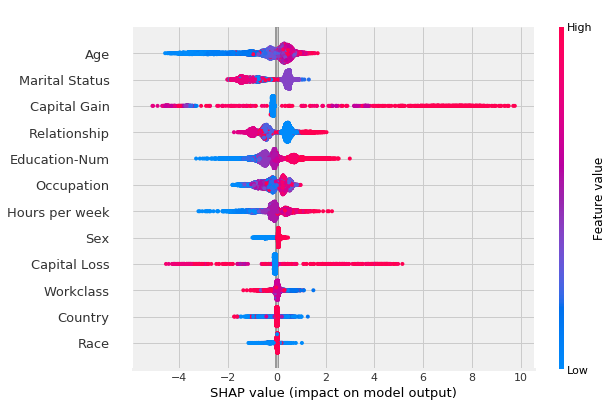

In [208]:
shap.summary_plot(shap_values,X_test)

Lecture : "Age" et "Marital status" ont un impact plus important dans les prédictions du modèle que le "capital gain". Cependant la variable "capital gain" à plus d'impact sur les prédictions que les variables "Age" et "Marital Status" lorsque ses valeurs sont élevées. En d’autres mots la variable "capital gain" affecte quelques prédictions lorsque le montant est important tandis que "Age" et "marital status" affecte toutes les prédictions par de petites valeurs.

##### Dépendance partielle
Principe similaire au dépendance partielle de skater mais le calcul est différent. SHAP se base sur ces SHAP values.

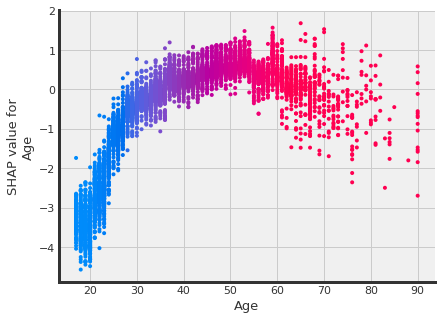

In [106]:
shap.dependence_plot(ind='Age', interaction_index='Age',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

Comme nous avons pu l'observer les personnes se trouvant au milieu ont une shap value plus élevée ce qui pousse le modèle à prédire que ces personnes sont plus probables à avoir un salaire sup. à 50k.

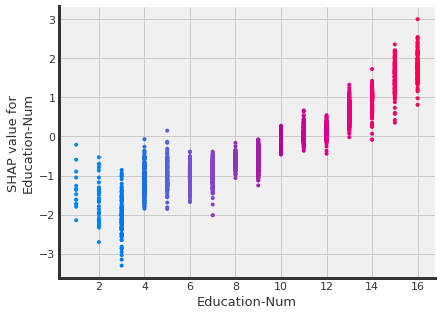

In [107]:
shap.dependence_plot(ind='Education-Num', interaction_index='Education-Num',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

Plus le niveau d'étude est élevé plus on a de chance d'avoir un salaire sup à 50k.

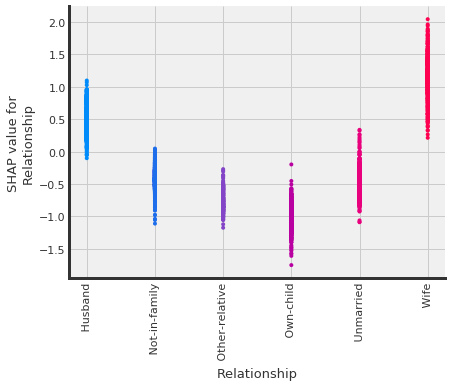

In [108]:
shap.dependence_plot(ind='Relationship', interaction_index='Relationship',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

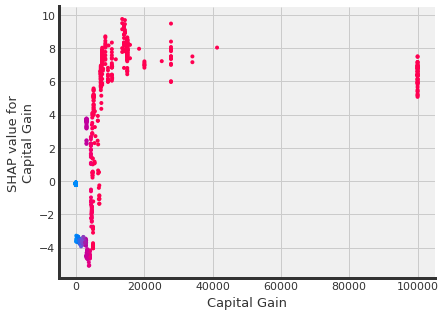

In [109]:
shap.dependence_plot(ind='Capital Gain', interaction_index='Capital Gain',
                     shap_values=shap_values, 
                     features=X_test,  
                     display_features=X_test_disp)

##### PDP biredirectionnel

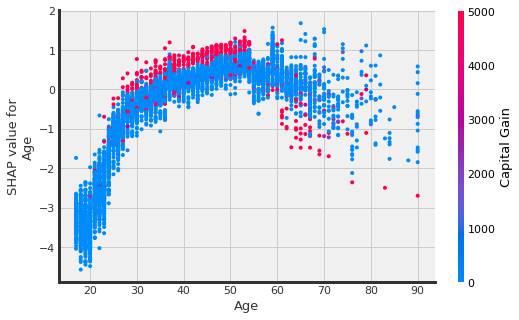

In [111]:
shap.dependence_plot(ind='Age', interaction_index='Capital Gain', 
                     shap_values=shap_values, features=X_test, 
                     display_features=X_test_disp)

Avoir un capital gain élevé entre 30 et 50 ans pousse a avoir un salaire sup à 50k.

## Conclusion

Les 3 packages ont leurs défauts et qualités. Le plus utilisé parmi les 3 est SHAP par ces bases solides de calculs et la participation de nombreux chercheurs à l'élaboration et l'amélioration du package. Cependant LIME ainsi que ELI5 peuvent très bien être utilisé pour expliquer au métier les prédictions de nos modèles plus au moins complexe.

##### "Comprendre le machine learning par du machine learning"